In [154]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from glob import glob
from os.path import join
from IPython.display import Image
from keras.models import load_model
import keras.backend as K
from deepsky.gan import rescale_data, unscale_data, stack_gen_disc
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [8]:
configs = pd.read_csv("/scratch/dgagne/arm_gan/gan_param_combos.csv", index_col="Index")

In [9]:
configs

,Index,batch_size,leaky_relu_alpha,learning_rate,min_data_width,max_conv_filters,filter_width,generator_input_size,min_conv_filters,beta_one
0,0,256,0.2,0.00020,4,256,5,100,32,0.2
1,1,256,0.2,0.00020,4,256,5,100,64,0.2
2,2,256,0.2,0.00020,4,512,5,100,32,0.2
3,3,256,0.2,0.00020,4,512,5,100,64,0.2
4,4,256,0.2,0.00002,4,256,5,100,32,0.2
5,5,256,0.2,0.00002,4,256,5,100,64,0.2
6,6,256,0.2,0.00002,4,512,5,100,32,0.2
7,7,256,0.2,0.00002,4,512,5,100,64,0.2


In [114]:
gan_patch_files = sorted(glob("/scratch/dgagne/arm_gan/gan_gen_patches_*_epoch_0020.nc"))
out_dir = "/scratch/dgagne/arm_gan_images/"
for gan_patch_file in gan_patch_files:
    print(gan_patch_file)
    gan_patch_set = xr.open_dataset(gan_patch_file)
    gan_patch_info = gan_patch_file[:-3].split("/")[-1].split("_")
    fig, axes = plt.subplots(8, 16, figsize=(12, 6))
    ax_flat = axes.ravel()
    for a, ax in enumerate(ax_flat):
        ax.imshow(gan_patch_set["gen_patch"][a])
        ax.axis("off")
    fig.suptitle("Synthetic TSI Images GAN Config {0} Epoch {1}".format(gan_patch_info[3], gan_patch_info[5]))
    plt.savefig(join(out_dir, "gan_gen_images_config_{0}_epoch_{1}.png".format(gan_patch_info[3], gan_patch_info[5])),
                bbox_inches="tight",
                dpi=200)
    plt.close()
    gan_patch_set.close()

/scratch/dgagne/arm_gan/gan_gen_patches_000000_epoch_0020.nc
/scratch/dgagne/arm_gan/gan_gen_patches_000001_epoch_0020.nc
/scratch/dgagne/arm_gan/gan_gen_patches_000002_epoch_0020.nc
/scratch/dgagne/arm_gan/gan_gen_patches_000003_epoch_0020.nc
/scratch/dgagne/arm_gan/gan_gen_patches_000004_epoch_0020.nc
/scratch/dgagne/arm_gan/gan_gen_patches_000005_epoch_0020.nc
/scratch/dgagne/arm_gan/gan_gen_patches_000006_epoch_0020.nc
/scratch/dgagne/arm_gan/gan_gen_patches_000007_epoch_0020.nc


In [21]:
gan_patch_files[0][:-3].split("/")[-1].split("_")

['gan', 'gen', 'patches', '000000', 'epoch', '0001']

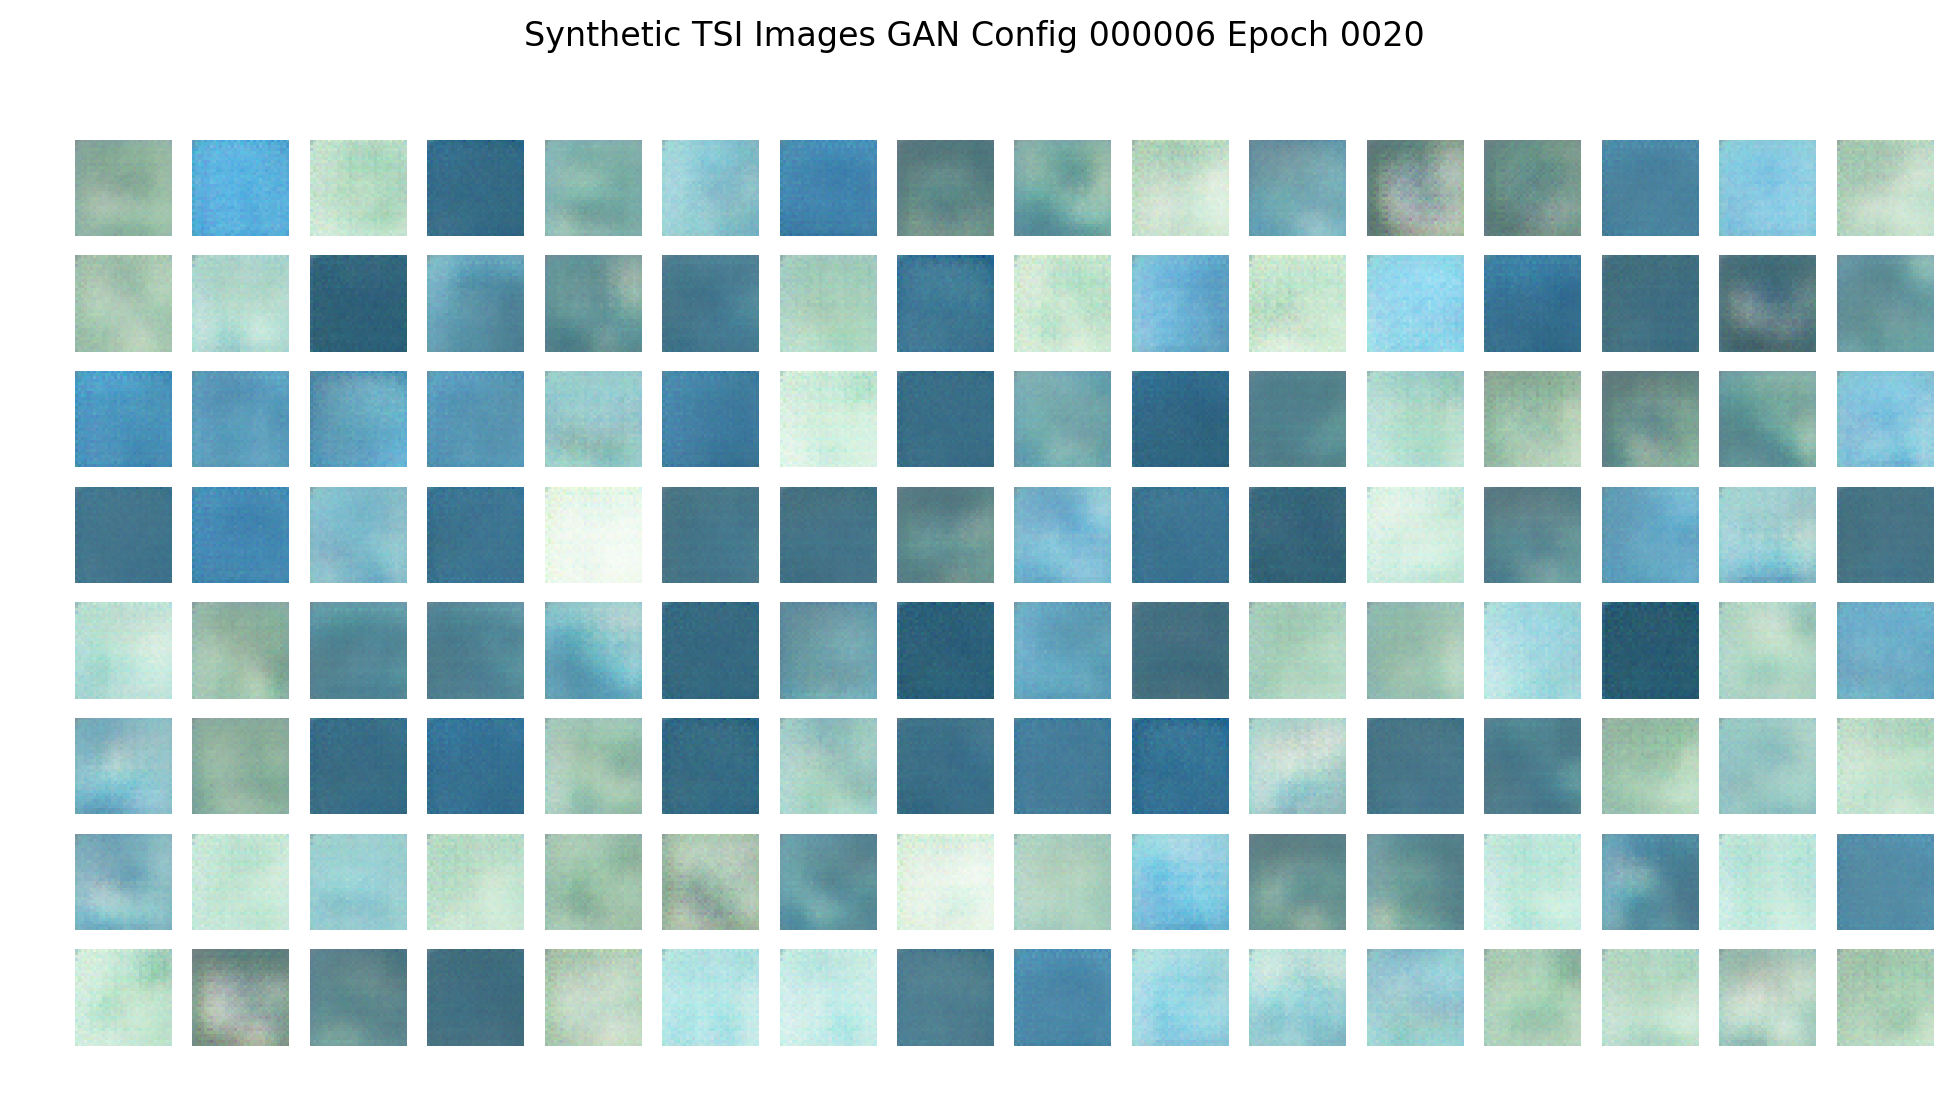

In [123]:
Image("/scratch/dgagne/arm_gan_images/gan_gen_images_config_000006_epoch_0020.png")

In [14]:
3008 / 64

47.0

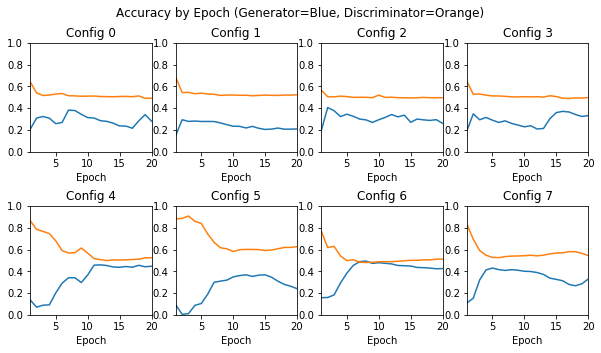

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
plt.subplots_adjust(hspace=0.5)
axef = axes.ravel()
for i in range(8):
    loss_hist = pd.read_csv("/scratch/dgagne/arm_gan/gan_loss_history_00000{0}.csv".format(i))
    loss_hist.groupby("Epoch").mean().plot(y=["Gen accuracy", "Disc accuracy"], ax=axef[i], legend=None,
                                           title="Config {0}".format(i), ylim=(0, 1))
plt.suptitle("Accuracy by Epoch (Generator=Blue, Discriminator=Orange)")

In [45]:
with K.tf.device("/gpu:1"):
    K.set_session(K.tf.Session(config=K.tf.ConfigProto(allow_soft_placement=True, 
                                                       gpu_options=K.tf.GPUOptions(allow_growth=True),
                                                       log_device_placement=False)))
    gen_model = load_model("/scratch/dgagne/arm_gan/gan_generator_000000_epoch_0050.h5")
    inputs = np.random.uniform(-1, 1, size=(128, 10))
    preds = gen_model.predict_on_batch(inputs)

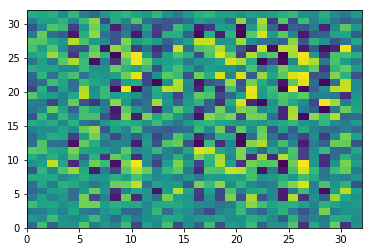

In [49]:
plt.pcolormesh(preds[0,:, :, 2])

In [51]:
gen_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 1024)          11264       dense_input_1[0][0]              
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 1024)          4096        dense_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 1024)          0           batchnormalization_1[0][0]       
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 2, 2, 256)     0           activation_1[0][0]               
___________________________________________________________________________________________

In [16]:
def load_tsi_data(data_path, variable_name, width=32, r_patch=(100, 100, 150, 150),
                  c_patch=(280, 120, 280, 120)):
    data_patches = []
    data_files = sorted(glob(join(data_path, "*.nc")))
    for data_file in data_files:
        ds = xr.open_dataset(data_file)
        for i in range(len(r_patch)):
            data_patches.append(ds[variable_name][:,
                                                  r_patch[i]:r_patch[i] + width,
                                                  c_patch[i]:c_patch[i] + width].values)
        ds.close()
    data = np.vstack(data_patches)
    return data

In [17]:
data = load_tsi_data("/scratch/dgagne/arm_tsi_sgp_nc/", "tsi_image")

In [18]:
scaled_data = rescale_data(data)

In [38]:
gray_data = rgb2gray(data)

(array([   3.,    5.,    3.,   11.,    5.,    8.,    8.,   16.,   28.,
          41.,   74.,   72.,  115.,  117.,   74.,  100.,  143.,  161.,
          35.,    5.]),
 array([  2. ,   4.8,   7.6,  10.4,  13.2,  16. ,  18.8,  21.6,  24.4,
         27.2,  30. ,  32.8,  35.6,  38.4,  41.2,  44. ,  46.8,  49.6,
         52.4,  55.2,  58. ]),
 <a list of 20 Patch objects>)

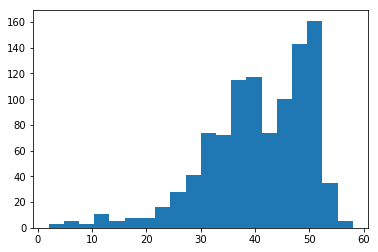

In [219]:
plt.hist((data[16004,:, :, 2] - data[16004, :, :, 0]).ravel(), 20)

(array([[  9.41000000e+02,   3.00000000e+00,   4.60000000e+01,
           3.60000000e+01,   4.90000000e+01,   4.30000000e+01,
           3.00000000e+01,   2.00000000e+01,   1.30000000e+01,
           6.00000000e+00,   4.00000000e+00,              nan,
           2.00000000e+00,              nan,              nan,
                      nan,              nan,              nan,
                      nan,              nan],
        [  1.02570000e+04,   1.38000000e+02,   1.35000000e+02,
           1.52000000e+02,   1.26000000e+02,   1.02000000e+02,
           8.70000000e+01,   6.80000000e+01,   5.70000000e+01,
           6.40000000e+01,   4.90000000e+01,   4.60000000e+01,
           3.50000000e+01,   2.00000000e+01,   1.00000000e+01,
           1.10000000e+01,   2.00000000e+00,              nan,
                      nan,              nan],
        [  4.87900000e+03,   3.63000000e+02,   1.03000000e+02,
           8.00000000e+01,   5.10000000e+01,   4.00000000e+01,
           3.00000000e+01,

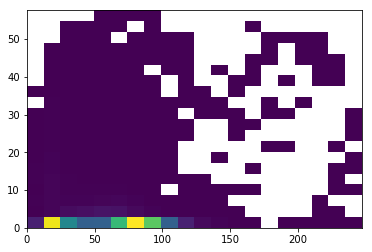

In [84]:
plt.hist2d((data[:,:, :, 2] - data[:, :, :, 0]).mean(axis=-1).mean(axis=-1), 
            (data[:,:, :, 2] - data[:, :, :, 0]).std(axis=-1).std(axis=-1), 20, cmin=1)

In [87]:
blue_red_diff = np.vstack(((data[:,:, :, 2] - data[:, :, :, 0]).mean(axis=-1).mean(axis=-1),
                           (data[:,:, :, 2] - data[:, :, :, 0]).std(axis=-1).std(axis=-1))).T

In [95]:
km = KMeans(n_clusters=4)
clusters = km.fit_predict((blue_red_diff - blue_red_diff.mean(axis=0)) / blue_red_diff.std(axis=0))

In [94]:
blue_red_diff.mean(axis=0)

array([ 60.19987649,   2.14882497])

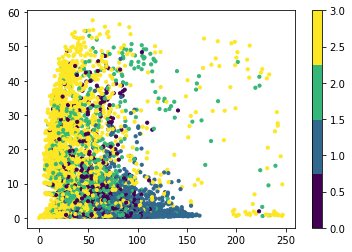

In [168]:
plt.scatter(blue_red_diff[:, 0], blue_red_diff[:, 1], 10, coded_clusters, cmap=plt.get_cmap("viridis", 4))
plt.colorbar()

In [175]:
np.where(coded_clusters==2)[0][0:20]

array([  3,   8,  25,  26,  44,  46,  49,  63,  64,  68,  80,  81,  83,
        84,  86,  87,  98, 100, 101, 102])

In [71]:
cloudy = np.where((data[:, 16, 16, 2] - data[:, 16, 16, 0]) < 50)[0]

In [74]:
cloudy[0:200:10]

array([  4,  16,  33,  51,  69, 325, 363, 532, 548, 565, 583, 599, 611,
       621, 634, 644, 655, 667, 677, 688])

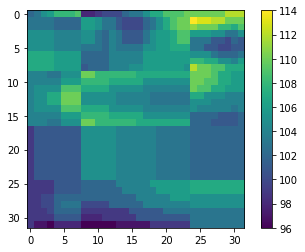

In [65]:
plt.imshow(data[2, :, :, 2] - data[2, :, :, 0])
plt.colorbar()

In [15]:
disc = load_model("/scratch/dgagne/arm_gan/gan_discriminator_000003_0010.h5")
gen = load_model("/scratch/dgagne/arm_gan/gan_generator_000003_epoch_0010.h5")
enc = load_model("/scratch/dgagne/arm_gan/gan_encoder_000003_epoch_0010.h5")

In [122]:
coded_data = enc.predict(scaled_data, batch_size=256)

In [124]:
decoded_data = gen.predict(coded_data, batch_size=256)

In [152]:
mean_image = gen.predict(coded_data[clusters==3].mean(axis=0).reshape(1, 100))

In [167]:
km = KMeans(n_clusters=4)
coded_clusters = km.fit_predict(coded_data)

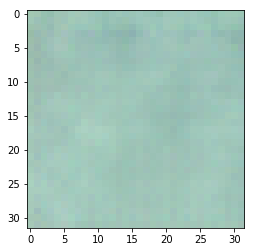

In [153]:
plt.imshow(unscale_data(mean_image[0]))

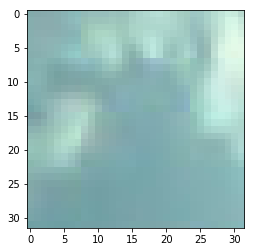

In [216]:
plt.imshow(data[16004])

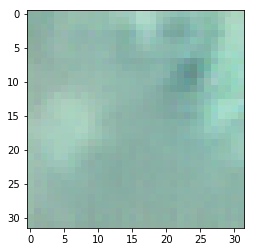

In [220]:
plt.imshow(unscale_data(decoded_data[16004]))

In [101]:
out = gen.predict(np.random.uniform(-1, 1, (200, 100)))

In [26]:
disc.predict(out)

array([[ 0.02896312],
       [ 0.01957038],
       [ 0.00998606],
       [ 0.00957492],
       [ 0.00622473],
       [ 0.01296386],
       [ 0.00814382],
       [ 0.00826758],
       [ 0.00967446],
       [ 0.00476949],
       [ 0.01593117],
       [ 0.0209915 ],
       [ 0.01528891],
       [ 0.01564102],
       [ 0.00835419],
       [ 0.01330591],
       [ 0.0129957 ],
       [ 0.00348757],
       [ 0.00484199],
       [ 0.01609866],
       [ 0.03240829],
       [ 0.0172978 ],
       [ 0.01376555],
       [ 0.01162159],
       [ 0.00920596],
       [ 0.004177  ],
       [ 0.00944949],
       [ 0.00692187],
       [ 0.00829954],
       [ 0.00695339],
       [ 0.00476578],
       [ 0.00997031],
       [ 0.00920265],
       [ 0.01993146],
       [ 0.02007554],
       [ 0.01501954],
       [ 0.00765255],
       [ 0.01004602],
       [ 0.01068832],
       [ 0.00757741],
       [ 0.0109506 ],
       [ 0.00567879],
       [ 0.01261071],
       [ 0.00768248],
       [ 0.02615402],
       [ 0

In [96]:
disc.layers[-2].get_weights()[0][0]

array([ 0.0387376], dtype=float32)

In [95]:
combo.layers[-2].get_weights()[0][0]

array([ 0.0387376], dtype=float32)

In [93]:
combo.layers[0].get_weights()[0][0,0]

0.03728842

In [94]:
gen.layers[0].get_weights()[0][0,0]

0.03728842

In [53]:
np.linspace(0, 8, 9).as

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.])